# Stock Market Direction Prediction (Yahoo Finance data)
- Difficulty: Intermediate → Advanced
- Project Purpose: Predict “up” or “down” stock movements; stretch → try SGDClassifier for large-scale learning.
- Points Examined: Logistic Regression with engineered features, SGDClassifier.
- Doc References: SGD.
- Why Useful: Realistic noisy data; introduces scalable solvers.

# Part 0 Data Download

In [1]:
!curl -L -o ./price-volume-data-for-all-us-stocks-etfs.zip https://www.kaggle.com/api/v1/datasets/download/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  491M  100  491M    0     0  18.8M      0  0:00:26  0:00:26 --:--:-- 21.1M4M  13.5M      0  0:00:36  0:00:08  0:00:28 18.7M


In [8]:
!unzip ./price-volume-data-for-all-us-stocks-etfs.zip

Archive:  ./price-volume-data-for-all-us-stocks-etfs.zip
  inflating: Data/ETFs/aadr.us.txt   
  inflating: Data/ETFs/aaxj.us.txt   
  inflating: Data/ETFs/acim.us.txt   
  inflating: Data/ETFs/actx.us.txt   
  inflating: Data/ETFs/acwf.us.txt   
  inflating: Data/ETFs/acwi.us.txt   
  inflating: Data/ETFs/acwv.us.txt   
  inflating: Data/ETFs/acwx.us.txt   
  inflating: Data/ETFs/adra.us.txt   
  inflating: Data/ETFs/adrd.us.txt   
  inflating: Data/ETFs/adre.us.txt   
  inflating: Data/ETFs/adru.us.txt   
  inflating: Data/ETFs/afk.us.txt    
  inflating: Data/ETFs/agf.us.txt    
  inflating: Data/ETFs/agg.us.txt    
  inflating: Data/ETFs/agnd.us.txt   
  inflating: Data/ETFs/agq.us.txt    
  inflating: Data/ETFs/agz.us.txt    
  inflating: Data/ETFs/agzd.us.txt   
  inflating: Data/ETFs/aia.us.txt    
  inflating: Data/ETFs/airr.us.txt   
  inflating: Data/ETFs/ald.us.txt    
  inflating: Data/ETFs/alfa.us.txt   
  inflating: Data/ETFs/alts.us.txt   
  inflating: Data/ETFs/amj.us.t

In [9]:
!ls

Data
ETFs
price-volume-data-for-all-us-stocks-etfs.zip
sp.ipynb
Stocks


In [10]:
# Wow that's a lot, will use one with many data: ./ETFs/adrd.us.txt

In [75]:
import pandas as pd
import numpy as np
data = pd.read_csv('./ETFs/adrd.us.txt')

In [76]:
data.head() # great this is ordered by data

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,17.331,17.440,17.331,17.433,7486,0
1,2005-02-28,17.635,17.635,17.301,17.386,13329,0
2,2005-03-01,17.425,17.425,17.395,17.417,3086,0
3,2005-03-02,17.378,17.410,17.370,17.370,3994,0
4,2005-03-03,17.417,17.425,17.386,17.386,3476,0


In [77]:
data.shape

(3186, 7)

# Part 1 Hypothesis & Plan
This time we will have a play on series data, and leverage between time series split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html and various features. We will also try SGD this time, the idea is just to have a play around with the classifier. Note that the toy data here only have 3186 examples, which is not too much and not that hard for any model, and SGD is not a must here.


## Features we gonna extract
- pct_change
- shift 1
- shift 2
- rolling mean 5
- rolling mean 20
These feature will be computed on all: Open, High, Low, Close, Volume, while they could be correlated, each of them might present some additional information that we care about.

## Target
This is an interesting one, for now, we will compute the Close Price between each day:
- If today's close < yesterday's close, label = -1
- If today's close >= yesterday's close, label = 1

We don't do equal here (which would be = 0) to avoid confusion for the model, otherwise, it will need to use OvR classification or multinomial, but 0 is just a special case.

We also don't treat the problem as a regression but as a classification, as we care more about the accuracy of up/down. Rather than how close the predictions are (e.g. a regression can say have only e-10 loss, but all a bit lower than actual, which is a terrible performance regarding up/down classification)

## Loss
Will use log_loss, as the assumption is that features are linearly related, don't currently see how here can be a polynomial, non-linear relationship. Maybe long term memory would help but for simplicity here, we just use rolling mean 5, 20 to keep some of the memory.

# Part 2 Preprocessing

In [78]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix

In [79]:
#tscv = TimeSeriesSplit(n_splits=3185,test_size=1, max_train_size=20) # Im having a feeling that we might want to avoid pass information too long ago to future?
#for train_index, test_index in tscv.split(data):
    #print(train_index, test_index)

# Got the idea of how TimeSeriesSplit work, but for now will only do 1-step next window prediction, so won't need this.

In [80]:
# Generate y
data['direction'] = np.where(data['Close'].shift(-1) < data['Close'], -1, 1)

In [81]:
def extract_series_factor(df, column):
    df[column+'_pct_change'] = df[column].pct_change()
    df[column+'_shift1'] = df[column].shift(1)
    df[column+'_shift2'] = df[column].shift(2)
    df[column+'_rolling5mean'] = df[column].rolling(5).mean()
    df[column+'_rolling20std'] = df[column].rolling(20).std()

In [82]:
for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    extract_series_factor(data, column)

In [83]:
data.dropna(inplace=True)

In [84]:
X = data[['Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt', 'Open_pct_change', 'Open_shift1', 'Open_shift2',
       'Open_rolling5mean', 'Open_rolling20std', 'High_pct_change',
       'High_shift1', 'High_shift2', 'High_rolling5mean', 'High_rolling20std',
       'Low_pct_change', 'Low_shift1', 'Low_shift2', 'Low_rolling5mean',
       'Low_rolling20std', 'Close_pct_change', 'Close_shift1', 'Close_shift2',
       'Close_rolling5mean', 'Close_rolling20std', 'Volume_pct_change',
       'Volume_shift1', 'Volume_shift2', 'Volume_rolling5mean',
       'Volume_rolling20std']]
y = data['direction']

In [85]:
# Scaling will be included in the pipeline

In [86]:
from math import floor
X_train, y_train, X_test, y_test = X.iloc[:-floor(X.shape[0]/5), :], y.iloc[:-floor(X.shape[0]/5)], X.iloc[-floor(X.shape[0]/5):, :], y.iloc[-floor(X.shape[0]/5):]

In [87]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2534, 31) (2534,) (633, 31) (633,)


# Part 3 Training

In [88]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

In [89]:
logistic = make_pipeline(StandardScaler(), SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    fit_intercept=False, # even all 0 is there should be a non-zero prediction?
))

hinge = make_pipeline(StandardScaler(), SGDClassifier(
    loss='hinge',
    penalty='elasticnet',
    fit_intercept=False,
))

In [90]:
logistic.fit(X_train, y_train)
hinge.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(fit_intercept=False, penalty='elasticnet'))])

In [91]:
print(classification_report(y_test, logistic.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.48      0.69      0.56       300
           1       0.54      0.32      0.40       333

    accuracy                           0.50       633
   macro avg       0.51      0.51      0.48       633
weighted avg       0.51      0.50      0.48       633



In [92]:
print(classification_report(y_test, hinge.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.39      0.11      0.17       300
           1       0.51      0.85      0.64       333

    accuracy                           0.50       633
   macro avg       0.45      0.48      0.40       633
weighted avg       0.45      0.50      0.42       633



In [93]:
# ??? Data Leakage ???? Even if some of those leaked by providing the rolling x mean,std, it shouldn't be that good.

# Before I did: data['direction'] = np.where(data['Close'].shift(1) < data['Close'], -1, 1), which already told us the solution, so got 0.99 score...

GPT's review:
🔹 Why your performance is ~0.5

Stock returns (esp. daily up/down) are very close to random noise once you control for obvious trends.

AUC ≈ 0.5 means “no predictive power” — i.e. model is guessing.

This isn’t a failure of your code, it’s the nature of the data: most liquid markets are designed to be efficient.

🔹 Why 0.7 would be insane

An AUC of 0.7 in this setting means you can correctly rank 70% of up vs down days.

That’s a huge edge — enough to build a profitable trading strategy even after transaction costs.

In real quant firms, an edge of 0.51–0.52 (slightly above random) can already be worth millions if managed properly.

So yeah, if you could consistently get 0.7 → you’d basically be a hedge fund legend 😅

🔹 What you actually learned here

How SGD behaves (online/large-scale learning, variance reduction, solvers).

How to avoid leakage in time-series ML.

Why real-world financial prediction is hard — a humbling but important lesson.

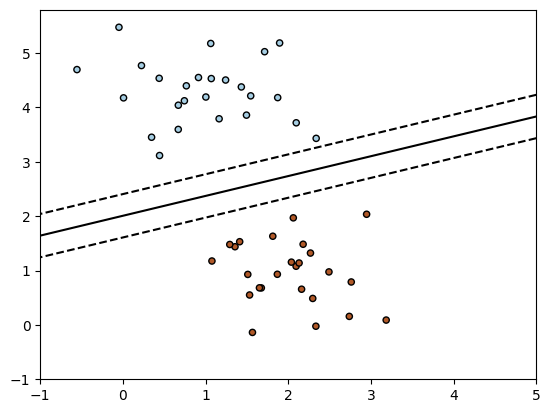

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.linear_model import SGDClassifier

# we create 50 separable points
X, Y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)

# fit the model
clf = SGDClassifier(loss="hinge", alpha=0.01, max_iter=200)

clf.fit(X, Y)

# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-1, 5, 10)
yy = np.linspace(-1, 5, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = clf.decision_function([[x1, x2]])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ["dashed", "solid", "dashed"]
colors = "k"
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolor="black", s=20)

plt.axis("tight")
plt.show()

In [4]:
Z

array([[ 6.62471389,  7.23505569,  7.84539749,  8.45573928,  9.06608108,
         9.67642288, 10.28676467, 10.89710647, 11.50744827, 12.11779006],
       [ 4.95318729,  5.56352909,  6.17387088,  6.78421268,  7.39455448,
         8.00489627,  8.61523807,  9.22557987,  9.83592166, 10.44626346],
       [ 3.28166068,  3.89200248,  4.50234428,  5.11268607,  5.72302787,
         6.33336967,  6.94371146,  7.55405326,  8.16439506,  8.77473685],
       [ 1.61013408,  2.22047587,  2.83081767,  3.44115947,  4.05150127,
         4.66184306,  5.27218486,  5.88252666,  6.49286845,  7.10321025],
       [-0.06139253,  0.54894927,  1.15929107,  1.76963286,  2.37997466,
         2.99031646,  3.60065825,  4.21100005,  4.82134185,  5.43168364],
       [-1.73291913, -1.12257734, -0.51223554,  0.09810626,  0.70844806,
         1.31878985,  1.92913165,  2.53947345,  3.14981524,  3.76015704],
       [-3.40444574, -2.79410394, -2.18376214, -1.57342035, -0.96307855,
        -0.35273675,  0.25760504,  0.86794684

In [2]:
X1

array([[-1.        , -0.33333333,  0.33333333,  1.        ,  1.66666667,
         2.33333333,  3.        ,  3.66666667,  4.33333333,  5.        ],
       [-1.        , -0.33333333,  0.33333333,  1.        ,  1.66666667,
         2.33333333,  3.        ,  3.66666667,  4.33333333,  5.        ],
       [-1.        , -0.33333333,  0.33333333,  1.        ,  1.66666667,
         2.33333333,  3.        ,  3.66666667,  4.33333333,  5.        ],
       [-1.        , -0.33333333,  0.33333333,  1.        ,  1.66666667,
         2.33333333,  3.        ,  3.66666667,  4.33333333,  5.        ],
       [-1.        , -0.33333333,  0.33333333,  1.        ,  1.66666667,
         2.33333333,  3.        ,  3.66666667,  4.33333333,  5.        ],
       [-1.        , -0.33333333,  0.33333333,  1.        ,  1.66666667,
         2.33333333,  3.        ,  3.66666667,  4.33333333,  5.        ],
       [-1.        , -0.33333333,  0.33333333,  1.        ,  1.66666667,
         2.33333333,  3.        ,  3.66666667

In [ ]:
from sklearn.linear_model import LogisticRegression